# Weather prediction

In this example, I want to predict the weather pattern in the city where I work.
The model will receive historical data from the city itself whose weather I want to forecast and three other cities quite far away.

**NOTE:** some of the data in the dataset that will be used are not actual measurements but data obtained from other calculations. Given the "for learning" purpose of this notebook, there is no problem.

In [1]:
import os
import requests
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

2024-04-21 10:44:11.626997: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-21 10:44:12.695827: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-21 10:44:15.594558: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Download data

The data will be extracted from meteostat.net, which allows it to be downloaded via API.

Station IDs can be found through their website.

In [2]:
STATIONS = {
    "Lecce": 16332,
    "Bari": 16270,
    "LameziaTerme": 16362,
}

EXAMPLE_STATION = "Lecce"

In [3]:
training_dataframes = dict()

csv_structure = """Order	Parameter	Description	Type
1	date	The date string (format: YYYY-MM-DD)	String
2	hour	The hour (UTC)	Integer
3	temp	The air temperature in °C	Float
4	dwpt	The dew point in °C	Float
5	rhum	The relative humidity in percent (%)	Integer
6	prcp	The one hour precipitation total in mm	Float
7	snow	The snow depth in mm	Integer
8	wdir	The wind direction in degrees (°)	Integer
9	wspd	The average wind speed in km/h	Float
10	wpgt	The peak wind gust in km/h	Float
11	pres	The sea-level air pressure in hPa	Float
12	tsun	The one hour sunshine total in minutes (m)	Integer
13	coco	The weather condition code	Integer"""

csv_column_names = [row.split('\t')[1] for row in csv_structure.split('\n')[1:]]

for station_name, station_id in STATIONS.items():
    zip_path = tf.keras.utils.get_file(
        origin=f'https://bulk.meteostat.net/v2/hourly/{station_id}.csv.gz',
        fname=f'meteostat_{station_id}.csv.gz',
        extract=False,
    )
    training_dataframes[station_name] = pd.read_csv(
        zip_path,
        compression='gzip',
        header=0,
        names=csv_column_names,
        usecols=['date', 'hour', 'temp', 'rhum', 'prcp', 'snow', 'wdir', 'wspd', 'pres'],
    )

In [4]:
training_dataframes[EXAMPLE_STATION].head()

,date,hour,temp,rhum,prcp,snow,wdir,wspd,pres
0,1944-01-01,0,9.6,93.0,NaN,NaN,158.0,25.9,1000.2
1,1944-01-01,1,8.5,93.0,NaN,NaN,158.0,22.3,1000.0
2,1944-01-01,2,8.5,93.0,NaN,NaN,113.0,9.4,999.4
3,1944-01-01,3,8.0,93.0,NaN,NaN,113.0,13.0,999.4
4,1944-01-01,4,8.0,93.0,NaN,NaN,158.0,14.8,999.5


In [5]:
training_dataframes[EXAMPLE_STATION].describe()

,hour,temp,rhum,prcp,snow,wdir,wspd,pres
count,318047.000000,308190.000000,307393.000000,28859.000000,0.0,262808.000000,315252.000000,103827.000000
mean,11.549183,16.993975,75.536779,0.066253,NaN,203.110921,12.702078,1015.184745
std,6.168551,7.842890,20.286048,0.385990,NaN,119.340454,10.546392,6.384825
min,0.000000,-9.000000,9.000000,0.000000,NaN,0.000000,0.000000,978.100000
25%,7.000000,11.000000,61.000000,0.000000,NaN,120.000000,3.600000,1011.400000
50%,12.000000,16.000000,82.000000,0.000000,NaN,203.000000,11.200000,1015.000000
75%,16.000000,23.000000,93.000000,0.000000,NaN,320.000000,18.400000,1019.000000
max,23.000000,43.400000,100.000000,13.900000,NaN,360.000000,148.300000,1052.500000


In [6]:
training_dataframes[EXAMPLE_STATION].dtypes

date     object
hour      int64
temp    float64
rhum    float64
prcp    float64
snow    float64
wdir    float64
wspd    float64
pres    float64
dtype: object

## Dates

In [7]:
for df in training_dataframes.values():
    print(df.shape)

(318047, 9)
(454418, 9)
(319100, 9)


In [8]:
for station_name in training_dataframes.keys():
    training_dataframes[station_name] = training_dataframes[station_name][(training_dataframes[station_name]['date'] >= '2021-01-01') & (training_dataframes[station_name]['date'] < '2024-01-01')]

In [9]:
for station_name, df in training_dataframes.items():
    print(station_name, df.shape)

Lecce (26280, 9)
Bari (26280, 9)
LameziaTerme (26280, 9)


In [10]:
for df in training_dataframes.values():
    df.set_index(pd.to_datetime(df['date'] + ' ' + df['hour'].apply(str).str.zfill(2) + ':00:00'), inplace=True)

In [11]:
for station, dataframe in training_dataframes.items():
    dataframe.drop(["date", "hour"], inplace=True, axis=1)

## Merge

In [12]:
df = None

for station_name, station_df in training_dataframes.items():
    if df is None:
        df = station_df.rename(columns={name: f"{name}_{station_name}" for name in station_df.columns})
    else:
        df = pd.concat([df, station_df.rename(columns={name: f"{name}_{station_name}" for name in station_df.columns})], axis=1)

df

,temp_Lecce,rhum_Lecce,prcp_Lecce,snow_Lecce,wdir_Lecce,wspd_Lecce,pres_Lecce,temp_Bari,rhum_Bari,prcp_Bari,...,wdir_Bari,wspd_Bari,pres_Bari,temp_LameziaTerme,rhum_LameziaTerme,prcp_LameziaTerme,snow_LameziaTerme,wdir_LameziaTerme,wspd_LameziaTerme,pres_LameziaTerme
2021-01-01 00:00:00,3.2,99.0,NaN,NaN,0.0,0.0,1014.7,3.4,86.0,NaN,...,220.0,11.2,1014.1,7.0,93.0,NaN,NaN,289.0,9.3,1015.0
2021-01-01 01:00:00,3.0,100.0,NaN,NaN,0.0,0.0,1014.0,3.0,87.0,NaN,...,220.0,11.2,1014.0,7.0,93.0,NaN,NaN,160.0,7.6,1016.0
2021-01-01 02:00:00,3.0,100.0,NaN,NaN,0.0,0.0,1014.0,4.0,81.0,NaN,...,220.0,13.0,1014.0,9.0,94.0,NaN,NaN,180.0,9.4,1016.0
2021-01-01 03:00:00,2.6,99.0,NaN,NaN,0.0,0.0,1015.1,3.2,86.0,NaN,...,210.0,11.2,1014.4,7.9,94.0,NaN,NaN,33.0,3.6,1016.3
2021-01-01 04:00:00,3.0,93.0,NaN,NaN,0.0,0.0,1015.0,3.0,87.0,NaN,...,210.0,13.0,1014.0,7.0,93.0,NaN,NaN,60.0,9.4,1016.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,12.2,96.0,0.0,NaN,110.0,5.4,1019.0,11.0,82.0,0.0,...,200.0,14.8,1017.5,12.0,88.0,0.0,NaN,130.0,9.4,1019.0
2023-12-31 20:00:00,12.0,96.0,0.0,NaN,150.0,3.6,1019.4,11.0,88.0,0.0,...,200.0,18.4,1017.4,12.0,88.0,0.0,NaN,350.0,5.4,1019.0
2023-12-31 21:00:00,12.2,96.0,0.0,NaN,130.0,5.4,1019.4,10.7,88.0,0.0,...,190.0,11.2,1017.1,11.8,89.0,0.0,NaN,120.0,7.6,1019.4
2023-12-31 22:00:00,12.4,96.0,0.0,NaN,140.0,5.4,1019.4,11.0,88.0,0.0,...,190.0,13.0,1017.3,11.0,88.0,0.0,NaN,60.0,7.6,1019.0


In [13]:
df['hour'] = df.index.hour
df['day'] = df.index.dayofyear

## NaN to 0

In [14]:
df.fillna(0, inplace=True)

In [15]:
df.describe()

,temp_Lecce,rhum_Lecce,prcp_Lecce,snow_Lecce,wdir_Lecce,wspd_Lecce,pres_Lecce,temp_Bari,rhum_Bari,prcp_Bari,...,pres_Bari,temp_LameziaTerme,rhum_LameziaTerme,prcp_LameziaTerme,snow_LameziaTerme,wdir_LameziaTerme,wspd_LameziaTerme,pres_LameziaTerme,hour,day
count,26280.000000,26280.000000,26280.000000,26280.0,26280.000000,26280.000000,26280.000000,26280.000000,26280.000000,26280.000000,...,26280.000000,26280.000000,26280.000000,26280.000000,26280.0,26280.000000,26280.000000,26280.000000,26280.000000,26280.000000
mean,17.252865,79.895129,0.065837,0.0,210.057420,12.677504,1015.494003,17.081438,68.324848,0.007435,...,1015.598653,17.641161,75.369977,0.062260,0.0,168.951104,13.688124,1016.244536,11.500000,183.000000
std,8.189206,18.147330,0.385830,0.0,116.875266,8.570561,6.339795,7.623695,18.304033,0.131054,...,6.785445,6.981819,15.991957,0.363328,0.0,94.377915,8.570395,6.117174,6.922318,105.368033
min,-3.000000,18.000000,0.000000,0.0,0.000000,0.000000,988.400000,-1.000000,0.000000,0.000000,...,990.000000,-3.000000,11.000000,0.000000,0.0,0.000000,0.000000,987.000000,0.000000,1.000000
25%,11.000000,67.000000,0.000000,0.0,130.000000,5.400000,1011.800000,11.000000,55.000000,0.000000,...,1011.700000,12.800000,66.000000,0.000000,0.0,70.000000,7.600000,1012.600000,5.750000,92.000000
50%,16.200000,87.000000,0.000000,0.0,220.000000,11.200000,1015.000000,16.300000,68.000000,0.000000,...,1015.300000,17.000000,77.000000,0.000000,0.0,210.000000,11.200000,1016.000000,11.500000,183.000000
75%,23.400000,95.000000,0.000000,0.0,330.000000,18.400000,1019.000000,23.000000,83.000000,0.000000,...,1019.500000,23.000000,88.000000,0.000000,0.0,260.000000,18.400000,1019.700000,17.250000,274.000000
max,41.600000,100.000000,13.900000,0.0,360.000000,51.800000,1037.000000,44.000000,100.000000,7.000000,...,1037.300000,42.000000,100.000000,13.200000,0.0,360.000000,57.600000,1036.500000,23.000000,365.000000


## Convert wind to vector

Wind information is given to us in terms of speed and direction, but to make the prediction, it is better to convert it to speed on the x and y axes, so as to reduce the weight that wind direction might have in the case of low wind.

In [16]:
for station in STATIONS.keys():
    wv = df.pop(f"wspd_{station}")
    wd_rad = df.pop(f"wdir_{station}") * np.pi / 180

    df[f"wx_{station}"] = wv * np.cos(wd_rad)
    df[f"wy_{station}"] = wv * np.sin(wd_rad)

## Analyze

In [17]:
df.describe(include="all").transpose()

,count,mean,std,min,25%,50%,75%,max
temp_Lecce,26280.0,17.252865,8.189206,-3.000000,11.000000,1.620000e+01,23.400000,41.600000
rhum_Lecce,26280.0,79.895129,18.147330,18.000000,67.000000,8.700000e+01,95.000000,100.000000
prcp_Lecce,26280.0,0.065837,0.385830,0.000000,0.000000,0.000000e+00,0.000000,13.900000
snow_Lecce,26280.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
pres_Lecce,26280.0,1015.494003,6.339795,988.400000,1011.800000,1.015000e+03,1019.000000,1037.000000
temp_Bari,26280.0,17.081438,7.623695,-1.000000,11.000000,1.630000e+01,23.000000,44.000000
rhum_Bari,26280.0,68.324848,18.304033,0.000000,55.000000,6.800000e+01,83.000000,100.000000
prcp_Bari,26280.0,0.007435,0.131054,0.000000,0.000000,0.000000e+00,0.000000,7.000000
snow_Bari,26280.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
pres_Bari,26280.0,1015.598653,6.785445,990.000000,1011.700000,1.015300e+03,1019.500000,1037.300000


## Normalization

In [18]:
mean = df.mean()
std = df.std()

df = (df - mean) / std.replace(0, 1)

pd.merge(mean.rename("mean"), std.rename("std"), left_index=True, right_index=True)

,mean,std
temp_Lecce,17.252865,8.189206
rhum_Lecce,79.895129,18.147330
prcp_Lecce,0.065837,0.385830
snow_Lecce,0.000000,0.000000
pres_Lecce,1015.494003,6.339795
temp_Bari,17.081438,7.623695
rhum_Bari,68.324848,18.304033
prcp_Bari,0.007435,0.131054
snow_Bari,0.000000,0.000000
pres_Bari,1015.598653,6.785445


In [19]:
df.describe(include="all").transpose()

,count,mean,std,min,25%,50%,75%,max
temp_Lecce,26280.0,-2.336031e-16,1.0,-2.473117,-0.763550,-0.128567,0.750639,2.973076
rhum_Lecce,26280.0,-3.157968e-16,1.0,-3.410702,-0.710580,0.391511,0.832347,1.107869
prcp_Lecce,26280.0,1.676318e-17,1.0,-0.170638,-0.170638,-0.170638,-0.170638,35.855634
snow_Lecce,26280.0,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
pres_Lecce,26280.0,1.128000e-14,1.0,-4.273641,-0.582669,-0.077921,0.553014,3.392223
temp_Bari,26280.0,4.715322e-16,1.0,-2.371742,-0.797702,-0.102501,0.776338,3.530907
rhum_Bari,26280.0,-3.460787e-16,1.0,-3.732776,-0.727973,-0.017747,0.801744,1.730501
prcp_Bari,26280.0,-6.488975e-18,1.0,-0.056735,-0.056735,-0.056735,-0.056735,53.356282
snow_Bari,26280.0,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
pres_Bari,26280.0,2.053112e-14,1.0,-3.772583,-0.574561,-0.044014,0.574958,3.198220


## Split the data

In [20]:
n = len(df)

train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

## Model

In [21]:
LABEL_COLUMNS = ['temp', 'rhum', 'prcp', 'snow', 'pres', 'wx', 'wy']
# LABEL_COLUMNS = ['temp']
label_indices = {name: i for i, name in enumerate(LABEL_COLUMNS)}

In [22]:
column_indices = {name: i for i, name in enumerate(df.columns)}
column_indices

{'temp_Lecce': 0,
 'rhum_Lecce': 1,
 'prcp_Lecce': 2,
 'snow_Lecce': 3,
 'pres_Lecce': 4,
 'temp_Bari': 5,
 'rhum_Bari': 6,
 'prcp_Bari': 7,
 'snow_Bari': 8,
 'pres_Bari': 9,
 'temp_LameziaTerme': 10,
 'rhum_LameziaTerme': 11,
 'prcp_LameziaTerme': 12,
 'snow_LameziaTerme': 13,
 'pres_LameziaTerme': 14,
 'hour': 15,
 'day': 16,
 'wx_Lecce': 17,
 'wy_Lecce': 18,
 'wx_Bari': 19,
 'wy_Bari': 20,
 'wx_LameziaTerme': 21,
 'wy_LameziaTerme': 22}

## Single prediction model

In [62]:
single_prediction_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=len(LABEL_COLUMNS)),
    tf.keras.layers.Reshape([1, -1]),
])

In [63]:
INPUT_WIDTH = 24 * 5
LABEL_WIDTH = 1
TOTAL_WIDTH = INPUT_WIDTH + LABEL_WIDTH

def split_window(features):
    inputs = features[:, slice(0, INPUT_WIDTH), :]
    labels = features[:, slice(INPUT_WIDTH, None), :]

    labels = tf.stack(
        [labels[:, :, column_indices[f'{name}_{EXAMPLE_STATION}']] for name in LABEL_COLUMNS],
        axis=-1,
    )

    inputs.set_shape([None, INPUT_WIDTH, None])
    labels.set_shape([None, LABEL_WIDTH, None])
    
    return inputs, labels

def make_single_prediction_dataset(data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=TOTAL_WIDTH,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,
    )

    ds = ds.map(split_window)
    
    return ds

In [64]:
print('Input shape:', next(iter(make_single_prediction_dataset(test_df)))[0].shape)
print('Output shape:', single_prediction_model(next(iter(make_single_prediction_dataset(test_df)))[0]).shape)

Input shape: (32, 120, 23)
Output shape: (32, 1, 7)


In [65]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=4,
    mode='min',
)

In [66]:
single_prediction_model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()],
)

In [67]:
EPOCHS = 20

history = single_prediction_model.fit(
    make_single_prediction_dataset(train_df),
    epochs=EPOCHS,
    validation_data=make_single_prediction_dataset(val_df),
    callbacks=[early_stopping],
)

Epoch 1/20
572/572 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.5539 - mean_absolute_error: 0.4768 - val_loss: 0.2781 - val_mean_absolute_error: 0.3046
Epoch 2/20
572/572 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.2446 - mean_absolute_error: 0.2632 - val_loss: 0.2378 - val_mean_absolute_error: 0.2588
Epoch 3/20
572/572 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.1990 - mean_absolute_error: 0.2267 - val_loss: 0.2357 - val_mean_absolute_error: 0.2548
Epoch 4/20
572/572 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.1810 - mean_absolute_error: 0.2144 - val_loss: 0.2213 - val_mean_absolute_error: 0.2419
Epoch 5/20
572/572 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.1616 - mean_absolute_error: 0.2015 - val_loss: 0.2293 - val_mean_absolute_error: 0.2413
Epoch 6/20
572/572 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.1512 - mean_absolute_error: 0.1952 - val_loss: 0.2304 - val_mean_absolute_error: 0.2348
Epoch 7/20
572/572 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.1439 - mean_absolute_error: 0.1

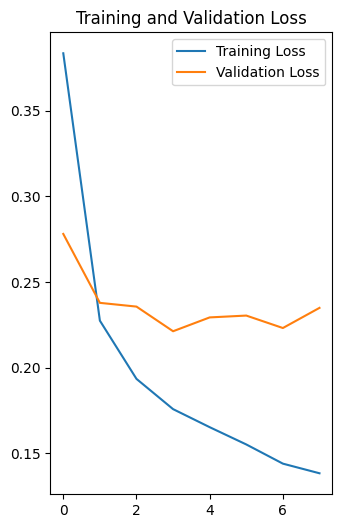

In [69]:
loss = single_prediction_model.history.history['loss']
val_loss = single_prediction_model.history.history['val_loss']

plt.subplot(1, 2, 2)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

tf.Tensor([1.1935583], shape=(1,), dtype=float32)
tf.Tensor([0.20874853], shape=(1,), dtype=float32)
tf.Tensor([0.25155807], shape=(1,), dtype=float32)
tf.Tensor([1.3861948], shape=(1,), dtype=float32)
tf.Tensor([1.017724], shape=(1,), dtype=float32)


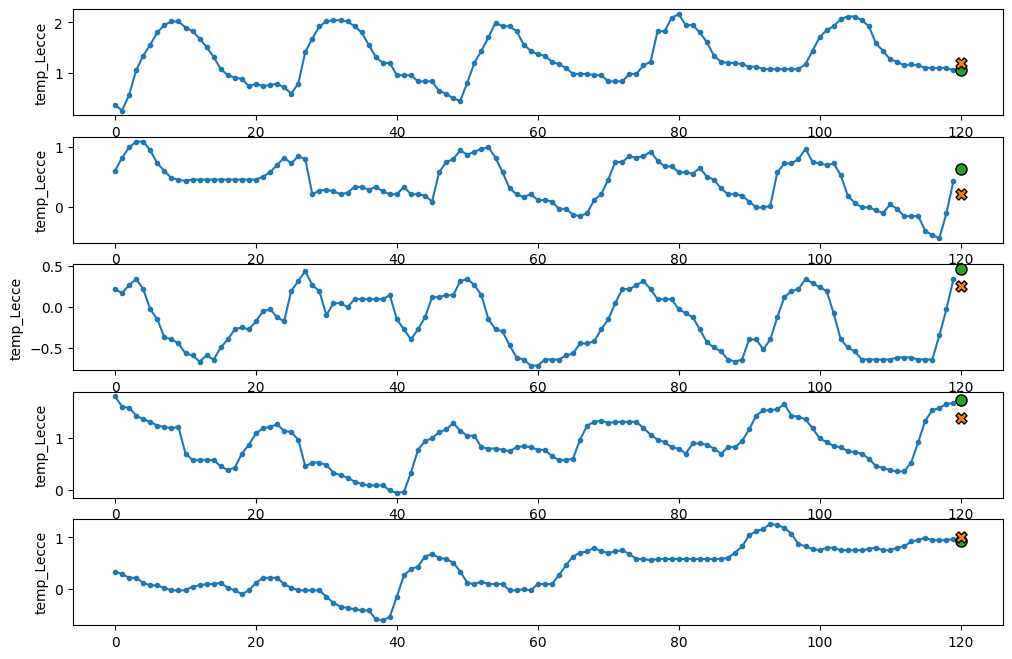

In [72]:
test_inputs, test_labels = next(iter(make_single_prediction_dataset(test_df)))
plt.figure(figsize=(12, 8))
label_col = 'temp'
plot_col=f'{label_col}_{EXAMPLE_STATION}'
plot_col_index = column_indices[plot_col]
label_col_index = label_indices[label_col]
predictions = single_prediction_model(test_inputs)

SUBPLOTS = 5

for n in range(SUBPLOTS):
    plt.subplot(SUBPLOTS, 1, n+1)
    plt.ylabel(plot_col)
    plt.plot(
        np.arange(INPUT_WIDTH),
        test_inputs[n, :, plot_col_index],
        label='Inputs',
        marker='.',
        zorder=-10,
    )
    plt.scatter(
        [INPUT_WIDTH],
        test_labels[n, :, label_col_index],
        edgecolors='k',
        label='Labels',
        c='#2ca02c',
        s=64,
    )
    plt.scatter(
        [INPUT_WIDTH],
        predictions[n, :, label_col_index],
        marker='X',
        edgecolors='k',
        label='Predictions',
        c='#ff7f0e',
        s=64,
    )

    print(predictions[n, :, label_col_index])